#### Importing thenecessary libraries

In [13]:
#data loading and manupilations
import scipy
import pandas as pd
import numpy as np

#system 
import platform

#plotting 
import matplotlib.pyplot as plt
import seaborn as sns

#### Loading Data files

In [14]:
# Load the .mat file

if platform.system() == 'Windows':
    mat_file_path = r'D:\Academic\Optimum Signal Processing\Project\Data\submarine.mat'  # Use raw string (r'...') to avoid escaping issues
elif platform.system() == 'Darwin':
    mat_file_path = '/Users/lakrama/Academic/Fall 2024/Optimum Signal Processing/Project/submarine.mat'
else:
    raise OSError("Unsupported operating system.")

RAW_DICT= scipy.io.loadmat(mat_file_path)

In [15]:
#assigning variables 

array_signals = RAW_DICT['X']
wavelength  =  RAW_DICT['lambda']
distance  = RAW_DICT ['d']

print('The shape of the signal array:',array_signals.shape)
print('The wavelength of the signal:', wavelength)
print('The distance between the array elements',distance)

The shape of the signal array: (6, 4096)
The wavelength of the signal: [[5.32]]
The distance between the array elements [[0.9]]


#### Estimiating the covariance matrix

1.  This is the spatial covariance matrix of signals received by the array elements. 
2.  This can be estimated using the signals samples that we have.
3.  The next option is to calculate the covariance matrix for a window of  time instances R(n) n= n,....n+l

In [16]:
#this the estimate of the covariance matrix
covariance_estimate = (array_signals @ array_signals.conj().T) / array_signals.shape[1]
print('Estimate of Covairance Matrix')
print('')
print(covariance_estimate)

Estimate of Covairance Matrix

[[ 0.99975588-1.44255315e-19j  0.72608788-1.99166377e-01j
   0.16057134-3.66431896e-01j -0.43937519-4.95019879e-01j
  -0.82365566-4.39518772e-01j -0.76951817-1.54187122e-01j]
 [ 0.72608788+1.99166377e-01j  0.99975588+6.42087958e-19j
   0.78424753-1.71944724e-01j  0.19362722-3.60296806e-01j
  -0.47530307-5.22455019e-01j -0.8032337 -4.72209887e-01j]
 [ 0.16057134+3.66431896e-01j  0.78424753+1.71944724e-01j
   0.99975587-7.73079513e-19j  0.73177176-1.81495580e-01j
   0.10263881-4.29208537e-01j -0.45885186-5.50202461e-01j]
 [-0.43937519+4.95019879e-01j  0.19362722+3.60296806e-01j
   0.73177176+1.81495580e-01j  0.99975591-1.68330914e-19j
   0.72191248-2.47875530e-01j  0.18893533-4.52429742e-01j]
 [-0.82365566+4.39518772e-01j -0.47530307+5.22455019e-01j
   0.10263881+4.29208537e-01j  0.72191248+2.47875530e-01j
   0.99975596-1.41610022e-19j  0.79835438-2.58855045e-01j]
 [-0.76951817+1.54187122e-01j -0.8032337 +4.72209887e-01j
  -0.45885186+5.50202461e-01j  0.188

In [17]:
#In case we want to compute the covarince matrix at time instance n using a window of l length 

def covariance_at_time_n(n,l,signal_array):
    if n and n+l  <= signal_array.shape[1]:
        array_window = signal_array[:,n:n+l]
        covariance = (array_window @ array_window.conj().T )
    else:
        print('time index out of range.') 
    return covariance


#### Defining the steering vectors 

In [18]:
def steeringvector(length,angle):
    #column vector with the indices 
    indices = np.arange(length).reshape((length,1))
    steering_vec = np.exp(1j * angle * indices)
    return steering_vec

####  Generating the theta range

In [19]:
def generate_theta_range(L):
    theta_range = np.array([-np.pi/2 + (np.pi / L) * k for k in range(L)])
    return theta_range

## Subspace Methods 

#### 1. Music Method

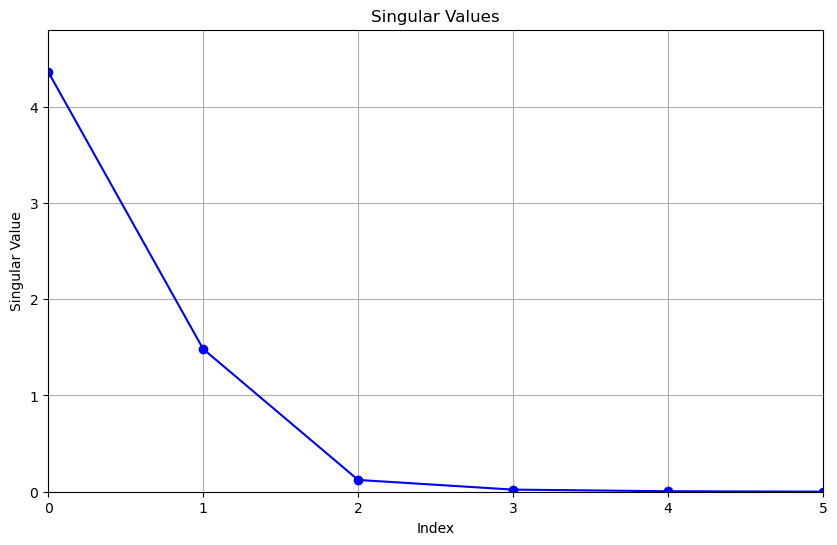

In [20]:
# first we start by perfoming singular value decomposition on the covariance matrix 

# Assuming U is the matrix of left singular vectors obtained from SVD
U, s, VT = np.linalg.svd(covariance_estimate)

#plotting the singular values of the matrix 
# Step 3: Plot the singular values
plt.figure(figsize=(10, 6))
plt.plot(s, marker='o', linestyle='-', color='b')
plt.title('Singular Values')
plt.xlabel('Index')
plt.ylabel('Singular Value')
plt.grid()
plt.xticks(np.arange(len(s)))  # Set x-ticks to match the indices of singular values
plt.xlim(0, len(s) - 1)  # Set x-limits
plt.ylim(0, np.max(s) * 1.1)  # Add a little space above the max singular value
plt.show()



*   Looking at this we can identify the separation between the signal and noise sub-spaces.
*   It seems the signal and noise subspace separation might be at eigen value #2 or #3. (remember the indexing starts from 0)

In [33]:
# Deciding eigen values
margin = 5

#signal subspace corresponding eigen vecotors
signal_subspace = U[:,:margin]
#noise subspace corresponding eigen vectors
noise_subspace = U[:,margin:]

#music method function 

def music_spectrum(noise_subspace,theta_range):
    spectrum = []
    for theta in theta_range:
        a = steeringvector(6,theta)
        spectrum.append((1 / np.abs(a.conj().T @ noise_subspace @ noise_subspace.conj().T @ a)).item())
    return spectrum

#generating the theta range 
theta_range = generate_theta_range(array_signals.shape[1])
spectrum = music_spectrum(noise_subspace,theta_range)




Let's plot the spectrum as a function of theta

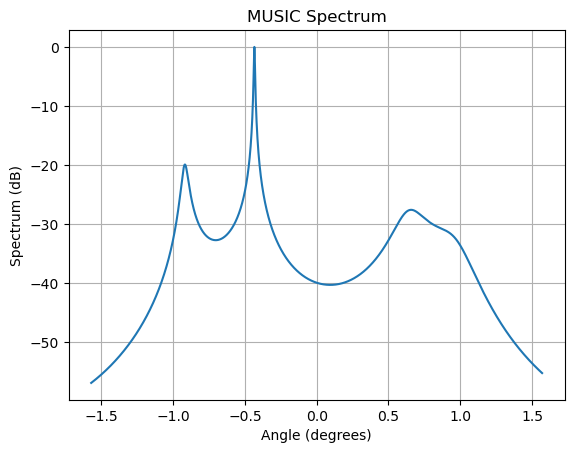

In [34]:
plt.plot(theta_range.tolist(), 10 * np.log10(spectrum / np.max(spectrum)))  # Normalize and plot in dB
plt.xlabel('Angle (degrees)')
plt.ylabel('Spectrum (dB)')
plt.title('MUSIC Spectrum')
plt.grid(True)
plt.show()

#### 2. Pisarenko's  Method 

1.  In Pisarenko's method we assume that the noise subspace is spanned by the last singular value of the auto-correlation matrix.
2.  And we know that the steering vectors/the signal subspace is orthoganal to the noise subspace.

In [28]:
def pisarenko_spectrum(singular_vectors, theta_range):
  
    # Smallest eigenvector corresponds to the noise subspace
    v = singular_vectors[:,-1] 

    # Compute the Pisarenko spectrum
    spectrum = []
    for theta in theta_range:
        a = steeringvector(6,theta)
        power = (1 / np.abs(a.conj().T @ v) ** 2).item()  # Pisarenko spectrum formula
        spectrum.append(power)

    return np.array(spectrum)


#generating the theta range 
theta_range = generate_theta_range(array_signals.shape[1])
#run the function for the pisarenko's spectrum
pisarenko_spec = pisarenko_spectrum(U,theta_range)



Plotting the Pisarenko's spectrum

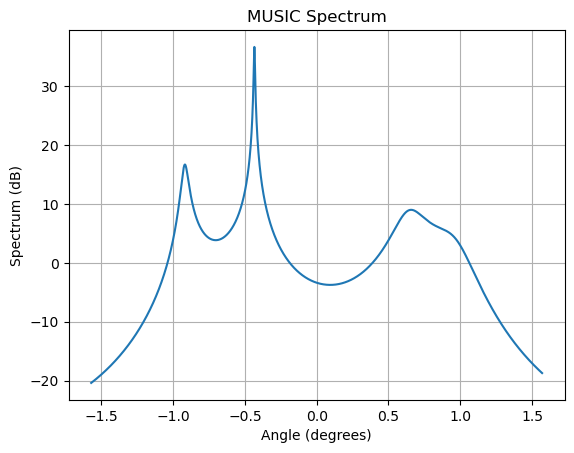

In [30]:
plt.plot(theta_range.tolist(), 10 * np.log10(pisarenko_spec / np.max(spectrum)))  # Normalize and plot in dB
plt.xlabel('Angle (degrees)')
plt.ylabel('Spectrum (dB)')
plt.title('MUSIC Spectrum')
plt.grid(True)
plt.show()

Important remark: If we set the last signular vector of the auto correlation matrix to span the noise subspace in the music method you will endup with the Pisarenko method.

## Sinusoidal Parameter Esitmation Methods

#### 1. Prony's Method

1.  Prony's method estimates the received signal as a sum of complex sinusoidals.
2.  This is achieved by fitting the data into an auto regressive process of a certain order.
3.  Once the auto regressive coefficients are the frequencies present in the signal can be found using the roots of the characteristic polynomial of the filter.
4.  As the frequencies are a function of the angle theta we can find the corresponding angle throught the routes of the characteristic equation.


In [39]:
def prony_method(signal, order):
    """Estimate the AR coefficients using Prony's method."""
    N = len(signal)
    X = np.zeros((N - order, order), dtype=complex)

    # Build the data matrix X
    for i in range(N - order):
        X[i, :] = signal[i:i + order]

    # Create the target vector b (next sample after each row of X)
    b = signal[order:]

    # Solve for AR coefficients a (using least squares)
    a = np.linalg.lstsq(X, b, rcond=None)[0]

    # Form the characteristic polynomial from the AR coefficients
    poly = np.concatenate(([1], -a))

    # Find the roots of the polynomial
    roots = np.roots(poly)

    # Convert roots to frequencies (angles of arrival)
    angles = np.angle(roots)
    return angles
